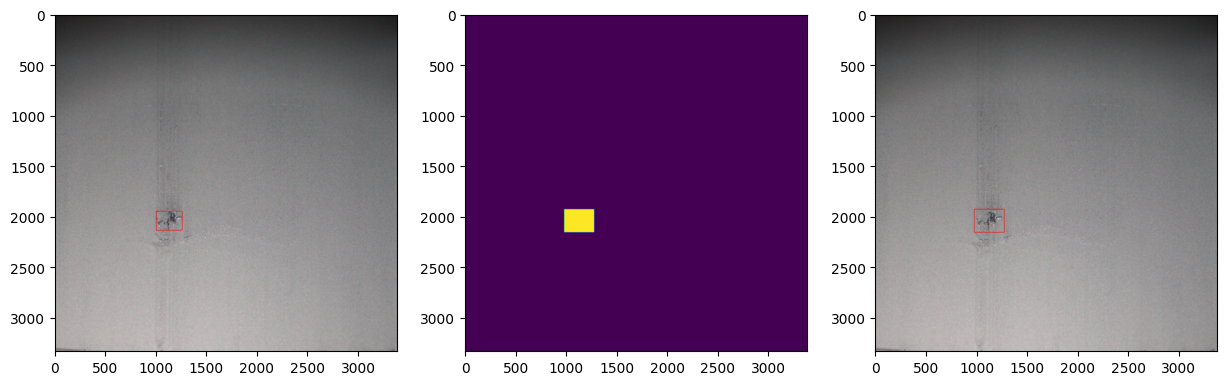

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Union
def normalize_coord(coord: List[Union[int, float]], 
                    w: int, 
                    h: int, 
                    expand = 0):
    x1, y1, x2, y2 = [int(c) for c in coord]
    expand = int(expand)
    x1 = max(x1 - expand, 0)
    x2 = min(x2 + expand, int(w))
    y1 = max(y1 - expand, 0)
    y2 = min(y2 + expand, int(h))

    return [x1, y1, x2, y2]

index = 96
img_path = './data/yolov5/Train/images/powder_uncover_{}.png'.format(index)
label_path = './data/yolov5/Train/labels/powder_uncover_{}.txt'.format(index)

im = cv2.imread(img_path)
im_h, im_w, im_c = im.shape
with open(label_path, 'r') as f:
    lines = f.readlines()


bboxs = []

expand = 20
new_mask = np.zeros((im_h, im_w), dtype=np.uint8)
for line in lines:
    line = [float(e) for e in line.split(' ')]
    cls_idx , center_x, center_y, w, h = line
    cls_idx = int(cls_idx)


    l_x, r_x = (center_x - (w / 2)) * im_w, (center_x + (w / 2)) * im_w
    l_y, r_y = (center_y - (h / 2)) * im_h, (center_y + (h / 2)) * im_h
    cv2.rectangle(im, (int(l_x), int(l_y)), (int(r_x), int(r_y)), (255, 0, 0), 3, cv2.LINE_AA)
    bboxs.append([l_x, l_y, r_x, r_y])

    l_x = max(int(l_x) - expand, 0)
    r_x = min(int(r_x) + expand, im_w)
    l_y = max(int(l_y) - expand, 0)
    r_y = min(int(r_y) + expand, im_h)
    new_mask[l_y : r_y, l_x:r_x] = 255

plt.figure(figsize=(15, 7))
ax = plt.subplot(1,3,1)    
ax.imshow(im)
ax = plt.subplot(1,3,2) 
ax.imshow(new_mask)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_mask, connectivity=8, ltype=cv2.CV_16U)
stats[:,2] += stats[:,0]
stats[:,3] += stats[:,1]
im = cv2.imread(img_path)
for i in range(1, num_labels):
    x1, y1, x2, y2, area = stats[i]
    x1, y1, x2, y2 = normalize_coord([x1, y1, x2, y2], im_w, im_h)
    cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3, cv2.LINE_AA)
ax = plt.subplot(1,3,3)    
ax.imshow(im)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Union
import os
from os.path import join
import shutil
def copy_file(src: str, dst: str) -> None:
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.copy(src , dst)

def normalize_coord(coord: List[Union[int, float]], 
                    w: int, 
                    h: int, 
                    expand = 0):
    x1, y1, x2, y2 = [int(c) for c in coord]
    expand = int(expand)
    x1 = max(x1 - expand, 0)
    x2 = min(x2 + expand, int(w))
    y1 = max(y1 - expand, 0)
    y2 = min(y2 + expand, int(h))

    return [x1, y1, x2, y2]
expand = 5
for split in ['Train', 'Val']:
    data_root = './data/fold1/{}'.format(split)
    new_data_root = './data/yolov5_fold1_precise/{}'.format(split)
    for img_name in os.listdir(join(data_root, 'images')):
        raw_name = img_name.split('.')[0]
        txt_name = raw_name + '.txt'

        img_path = join(data_root, 'images', img_name)
        txt_path = join(data_root, 'labels', txt_name)

        im = cv2.imread(img_path)
        im_h, im_w, im_c = im.shape
        with open(txt_path, 'r') as f:
            lines = f.readlines()

        new_mask = np.zeros((im_h, im_w), dtype=np.uint8)
        cls_idx = -1
        for line in lines:
            line = [float(e) for e in line.split(' ')]
            cls_idx , center_x, center_y, w, h = line
            cls_idx = int(cls_idx)
            x1, x2 = (center_x - (w / 2)) * im_w, (center_x + (w / 2)) * im_w
            y1, y2 = (center_y - (h / 2)) * im_h, (center_y + (h / 2)) * im_h
            x1, y1, x2, y2 = normalize_coord([x1, y1, x2, y2], im_w, im_h, expand=expand)
            new_mask[y1 : y2, x1:x2] = 255

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_mask, connectivity=8, ltype=cv2.CV_16U)
        stats[:,2] += stats[:,0]
        stats[:,3] += stats[:,1]
        lines = []
        if cls_idx == -1:
            raise ValueError("Some lable Error")
        for i in range(1, num_labels):
            x1, y1, x2, y2, area = stats[i]
            x1, y1, x2, y2 = normalize_coord([x1, y1, x2, y2], im_w, im_h)

            w, h = (x2 - x1), (y2 - y1)
            center_x, center_y = (x1 + (w / 2)), (y1 + (h / 2))

            center_x, center_y, w, h = center_x / im_w, center_y / im_h, w / im_w, h / im_h
            line = [cls_idx, center_x, center_y, w, h]
            line = ' '.join([str(c) for c in line]) + '\n'
            lines.append(line)
        new_label_path = join(new_data_root, 'labels')
        os.makedirs(new_label_path, exist_ok=True)
        with open(join(new_label_path, txt_name), 'w') as f:
            f.writelines(lines)
        copy_file(img_path, join(new_data_root, 'images', img_name))

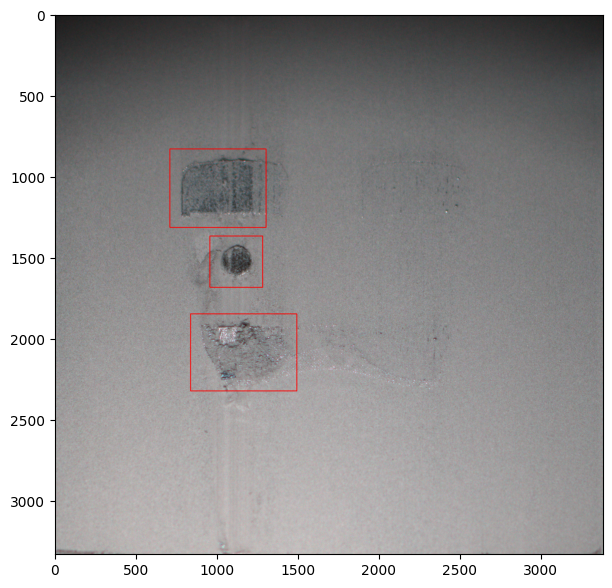

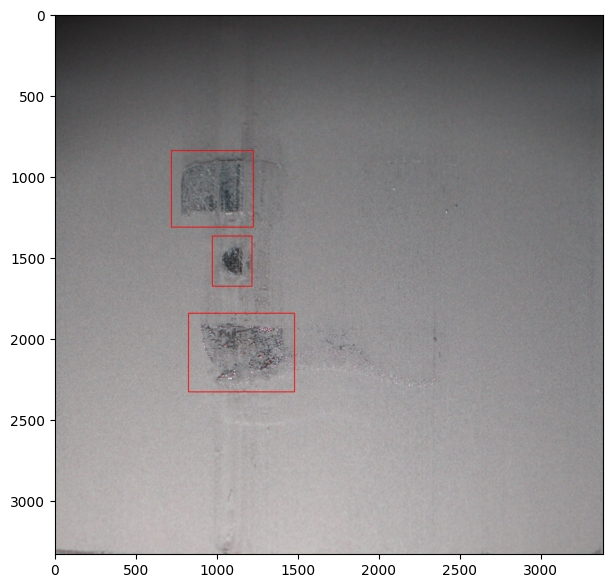

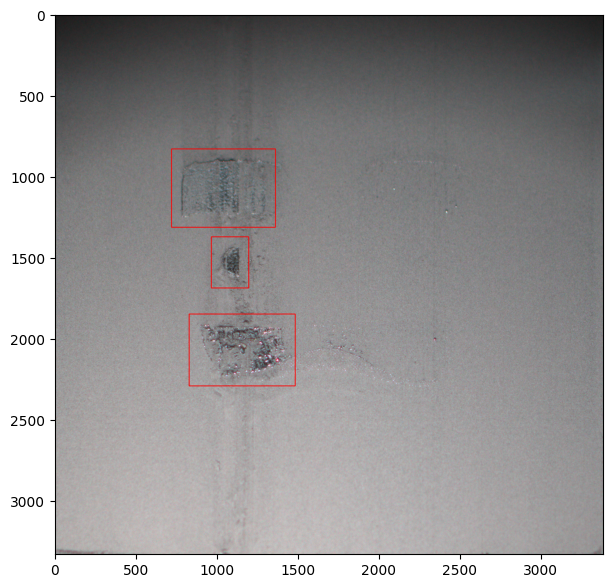

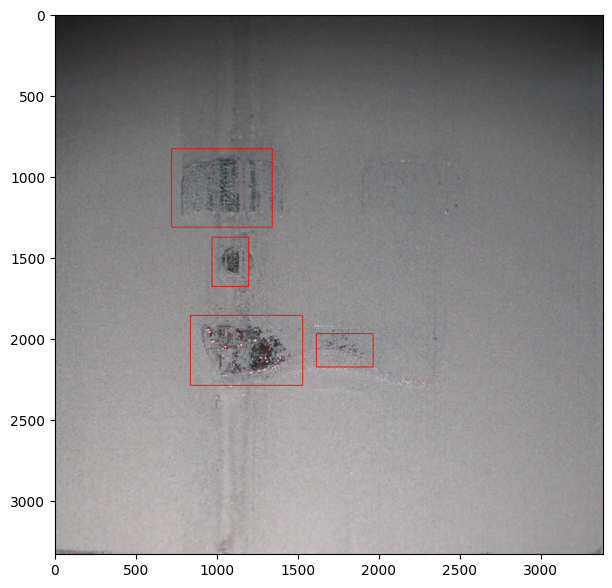

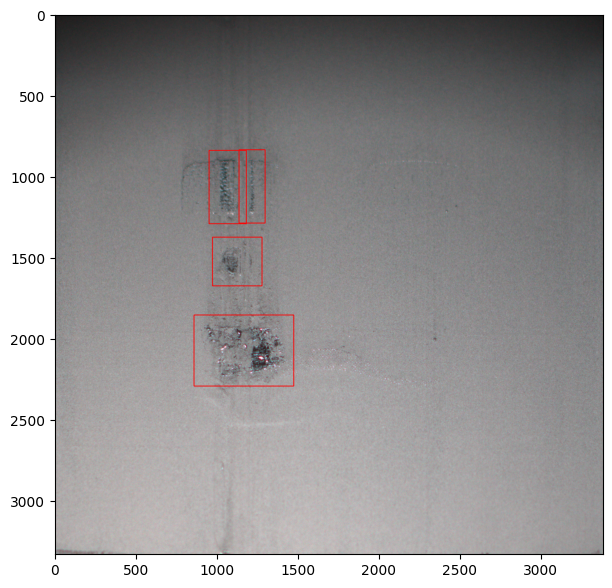

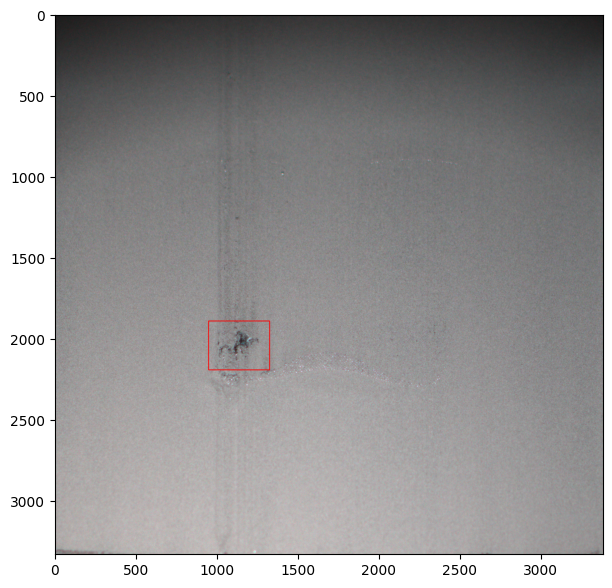

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Union
def normalize_coord(coord: List[Union[int, float]], 
                    w: int, 
                    h: int, 
                    expand = 0):
    x1, y1, x2, y2 = [int(c) for c in coord]
    expand = int(expand)
    x1 = max(x1 - expand, 0)
    x2 = min(x2 + expand, int(w))
    y1 = max(y1 - expand, 0)
    y2 = min(y2 + expand, int(h))

    return [x1, y1, x2, y2]

index = 15
for i in range(90,96):
    img_path = './data/yolov5_precise/Train/images/powder_uncover_{}.png'.format(i)
    label_path = './data/yolov5_precise/Train/labels/powder_uncover_{}.txt'.format(i)

    im = cv2.imread(img_path)
    im_h, im_w, im_c = im.shape
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        line = [float(e) for e in line.split(' ')]
        cls_idx , center_x, center_y, w, h = line
        cls_idx = int(cls_idx)
        x1, x2 = (center_x - (w / 2)) * im_w, (center_x + (w / 2)) * im_w
        y1, y2 = (center_y - (h / 2)) * im_h, (center_y + (h / 2)) * im_h
        x1, y1, x2, y2 = normalize_coord([x1, y1, x2, y2], im_w, im_h, expand=expand)
        cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3, cv2.LINE_AA)
    
    plt.figure(figsize=(10, 7))  
    plt.imshow(im)
